<img src="https://i.ibb.co/R6yBZxM/4.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

# Описание признаков в тестовом датасете:
* bodyType - тип кузова
* brand - марка автомобиля 
* car_url - адрес страницы с объявлением 
* color - цвет автомобиля
* complectation_dict - словарь с параметрами комплектации авто
* description - описание автомобиля 
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* equipment_dict - словарь оснащения авто 
* fuelType - тип топлива 
* image - изображение 
* mileage - пробег 
* modelDate - дата выпуска модели
* model_info - информация о модели
* model_name - название модели
* name - имя
* numberOfDoors - кол-во дверей
* parsing_unixtime - когда был произведен парсинг данных
* priceCurrency - валюта
* productionDate - год производства
* sell_id
* super_gen - словарь с дополинтельной информацией
* vehicleConfiguration - конфигурация транспортного средства
* vehicleTransmission - трансмиссия
* vendor - страна-изготовитель
* Владельцы - кол-во владельцев
* Владение - период владения
* ПТС
* Привод
* Руль
* Состояние
* Таможня

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import time
import json
import requests as r
import warnings
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
warnings.simplefilter('ignore')
from tqdm.notebook import tqdm
from pandas import Series
from bs4 import BeautifulSoup
from catboost import CatBoostRegressor
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV


In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
#запишем функцию для вычисления итоговой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

# Код парсинга

In [5]:
#в соответствии с условиями задачи, надо собрать данные о продажах автомобилей с пробегом в Москве:
START_URL='https://auto.ru/moskva/cars/used/'
#Создадим список из доступных ссылок
pages_url_list=[]


In [6]:
"""
while len(pages_url_list) < 4001
    for i in range(1,99):   
        response = r.get(START_URL+'?page=%s'%i)
        page = BeautifulSoup(response.text, 'html.parser')
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
            try:
                if link['href'] not in pages_url_list:
                    pages_url_list.append(link['href'])
            except:
                print('Except!')
                pass
    print(len(pages_url_list))  
    time.sleep(5)
    """

'\nwhile len(pages_url_list) < 4001\n    for i in range(1,99):   \n        response = r.get(START_URL+\'?page=%s\'%i)\n        page = BeautifulSoup(response.text, \'html.parser\')\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n            try:\n                if link[\'href\'] not in pages_url_list:\n                    pages_url_list.append(link[\'href\'])\n            except:\n                print(\'Except!\')\n                pass\n    print(len(pages_url_list))  \n    time.sleep(5)\n    '

Создаем датафрейм cars_list с учетом заранее проанализированных признаков. Учитываем условие, что авто должны быть с ценой.

In [7]:
"""cars_list = []
for item in pages_url_list:
    response = r.get(item)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
    if page.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        #span_str = 'CardInfoRow__cell'
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find('div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass

    else:
        print('Продана...')

    print('Ожидаю 0.1 секунды. Строк', len(cars_list))
    time.sleep(0.1)
    """

'cars_list = []\nfor item in pages_url_list:\n    response = r.get(item)\n    response.encoding = \'utf8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n    if page.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        #span_str = \'CardInfoRow__cell\'\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n            \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n            \'fuelType\': json_data[\'fuelType\'],\n    

In [8]:
# переводим в удобный для нас вид датафрейм
#df = pd.DataFrame(cars_list)
# проверяем на дубликаты, можно по двум признакам car_url или sell_id
#df['sell_id'].duplicated().sum()
# сохраняем в csv
#df.to_csv('cars_df.csv', index=False)

# Setup

In [9]:
VERSION    = 16
DIR_TRAIN  = '../input/cars-df2/' # подключил к ноутбуку внешний датасет
DIR_TRAIN20  = '../input/parsing-all-moscow-auto-ru-0909-2020/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [10]:
!ls '../input'

cars-df2  parsing-all-moscow-auto-ru-0909-2020	sf-dst-car-price-prediction


In [11]:
train = pd.read_csv(DIR_TRAIN + 'cars_df.csv') # созданный датасет для обучения модели
train_2020 = pd.read_csv(DIR_TRAIN20 + 'all_auto_ru_09_09_2020.csv')
test = pd.read_csv(DIR_TEST + 'test.csv')
sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

In [12]:
train.head(5)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,минивэн,MERCEDES,https://auto.ru/cars/used/sale/mercedes/v_klas...,чёрный,"Новый V class без пробега, в наличии. \nПоказ ...",2.1 LTR,190 N12,дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,15 км,...,2020,MINIVAN AUTOMATIC 2.1,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,14 945 000 ₽
1,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/rav_4/11...,серый,"RAV 4 2011 года, CVT, 2.0, 4x4, 158 л.с. Обслу...",2.0 LTR,158 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,180 000 км,...,2011,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1 150 000 ₽
2,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/glc_kl...,красный,Продаётся автомобиль Мерседес GLC 300 AMG. Цве...,2.0 LTR,245 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,47 000 км,...,2017,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3 200 000 ₽
3,купе,AUDI,https://auto.ru/cars/used/sale/audi/tt_rs/1104...,серый,Сделано по машине\nСт2\nКарбоновый руль\nКулек...,2.5 LTR,400 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,66 000 км,...,2016,COUPE ROBOT 2.5,роботизированная,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4 850 000 ₽
4,внедорожник 5 дв.,PORSCHE,https://auto.ru/cars/used/sale/porsche/macan/1...,коричневый,"Отличное состояние,оригинальный пробег,ездила ...",2.0 LTR,252 N12,бензин,https://autoru.naydex.net/F9Gs1rI48/42427dMKj-...,6 000 км,...,2019,ALLROAD_5_DOORS ROBOT 2.0,роботизированная,2 владельца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4 650 000 ₽


In [13]:
#Проверяем условие, что авто должны быть с ценой
train.price.isnull().values.any()

False

In [14]:
train.info()
#Проверяем на пустые записи
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37181 entries, 0 to 37180
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              37181 non-null  object 
 1   brand                 37181 non-null  object 
 2   car_url               37181 non-null  object 
 3   color                 37181 non-null  object 
 4   description           37181 non-null  object 
 5   engineDisplacement    37181 non-null  object 
 6   enginePower           37181 non-null  object 
 7   fuelType              37181 non-null  object 
 8   image                 37181 non-null  object 
 9   mileage               37181 non-null  object 
 10  modelDate             37181 non-null  float64
 11  model_name            37181 non-null  object 
 12  name                  37181 non-null  object 
 13  numberOfDoors         37181 non-null  float64
 14  priceCurrency         37181 non-null  object 
 15  productionDate     

bodyType                0
brand                   0
car_url                 0
color                   0
description             0
engineDisplacement      0
enginePower             0
fuelType                0
image                   0
mileage                 0
modelDate               0
model_name              0
name                    0
numberOfDoors           0
priceCurrency           0
productionDate          0
vehicleConfiguration    0
vehicleTransmission     0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
Состояние               0
Таможня                 0
price                   0
dtype: int64

In [15]:
test.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [16]:
test.info()

#Проверяем на пустые записи
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [17]:
print('Размерность тренировочного датасета: ', train.shape)
print('Размерность тестового датасета: ', test.shape)

Размерность тренировочного датасета:  (37181, 25)
Размерность тестового датасета:  (34686, 32)


## Data Preprocessing

По оценке датасета 2020 года (all_auto_ru_09_09_2020.csv) видно что цены в 2021 году сильно изменились. Причем цены на разные бренды менялись по-разному. 
Можно вычислить среднее по каждому бренду и узнать % роста. Затем уменьшить цену спарсенного датасета 2021 года на этот %

In [18]:
# удалим знак валюты и пробелы в цене

train['price'] = train['price'].apply(lambda x: str(x))
train.price = train.price.apply(lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

In [19]:
brands = train_2020.brand.unique()
display(train.price.head(7))

0    14945000
1     1150000
2     3200000
3     4850000
4     4650000
5     1080000
6     1979000
Name: price, dtype: int64

In [20]:
#Учтем инфляцию и изменим в трейне цены так, чтобы они были похожи на осень 2020 года
for brand in brands:
    mean20 = train_2020[train_2020["brand"]==brand].price.mean()
    
    mean21 = train[train["brand"]==brand].price.mean()
    inf = (mean21 - mean20)/mean20
    if inf > 0:
        train.loc[train["brand"]==brand, ['price']] = train.loc[train["brand"]==brand, ['price']].apply(lambda x: round(x / (1+inf),0))
display(train.price.head(7))

0    14945000.0
1      951539.0
2     3200000.0
3      645991.0
4     2991256.0
5     1080000.0
6     1381408.0
Name: price, dtype: float64

In [21]:
# удаляем дубликаты
train = train.drop_duplicates(subset=['car_url'])

In [22]:
# проверим датасеты на дубликаты по уникальному идентификатору объявления
train['car_url'].duplicated().sum()

0

In [23]:
test['sell_id'].duplicated().sum()

0

In [24]:
# нам удалось спарсить не все данные(либо в некоторых мы не увидели необходимости), содержащиеся в тестовом датафрейме
# удалим из тестового датафрейма эти признаки (их не так много)
test.drop(['complectation_dict', 'equipment_dict', 'model_info',
           'sell_id', 'super_gen', 'vendor','Владение'], axis=1, inplace=True)

In [25]:
test['price'] = 0
df_train = train
df_test = test

# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [26]:
# еще раз проверим на дубликаты
data = data.drop_duplicates(subset=['car_url'])

In [27]:
# используем модуль для быстрого первичного анализа данных
#pandas_profiling.ProfileReport(data)

Краткий итог: в тренировочной выборке 37181 объявлений, в тестовой - 34686. Всего данных после удаления дубликатов - 69181 объявлений. Имеется 28 признаков. Из числовых признаков у нас: modelDate, numberOfDoors, productionDate,parsing_unixtime. Остальные - типа Object. Пропуски в признаках price, parsing_unixtime появились исскуственно. Также добавился признак sample для обозначения принадлежности данных и последующего разделения.

# Рассмотрим каждый признак

In [28]:
# Будем добавлять признаки в определенный список:
# числовые:
num_cols = []

# бинарные
bin_cols = []

# категориальные
cat_cols = []

**bodyType**

In [29]:
data.bodyType.value_counts()

внедорожник 5 дв.          26391
седан                      24766
хэтчбек 5 дв.               4554
лифтбек                     4281
универсал 5 дв.             2427
минивэн                     1788
купе                        1552
компактвэн                   956
хэтчбек 3 дв.                890
пикап двойная кабина         494
купе-хардтоп                 288
внедорожник 3 дв.            213
фургон                       200
родстер                      168
кабриолет                    128
седан-хардтоп                 29
микровэн                      16
пикап одинарная кабина        11
пикап полуторная кабина        7
лимузин                        6
седан 2 дв.                    6
внедорожник открытый           4
тарга                          2
фастбек                        2
хэтчбек 4 дв.                  1
универсал 3 дв.                1
Name: bodyType, dtype: int64

In [30]:
#оставляем только первое слово - обозначение кузова
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())
data.bodyType.value_counts()

внедорожник      26608
седан            24772
хэтчбек           5445
лифтбек           4281
универсал         2428
минивэн           1788
купе              1552
компактвэн         956
пикап              512
купе-хардтоп       288
фургон             200
родстер            168
кабриолет          128
седан-хардтоп       29
микровэн            16
лимузин              6
фастбек              2
тарга                2
Name: bodyType, dtype: int64

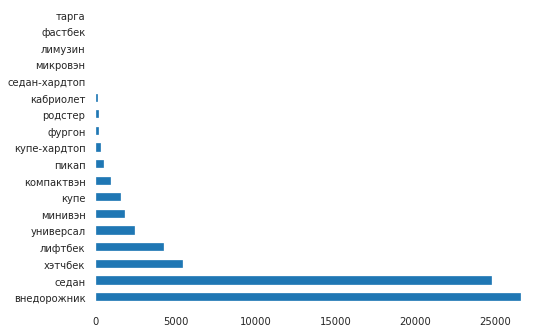

In [31]:
#посмотрим на распределение
data.bodyType.value_counts().plot.barh()

In [32]:
#пропусков нет,определяем его в "категориальные"
cat_cols.append('bodyType')

**brand**

In [33]:
data.brand.value_counts()

BMW           8447
VOLKSWAGEN    8368
MERCEDES      8074
NISSAN        8003
TOYOTA        7608
              ... 
MG               1
DAIHATSU         1
CHERYEXEED       1
DONGFENG         1
SATURN           1
Name: brand, Length: 75, dtype: int64

In [34]:
#пропусков нет,определяем его в "категориальные"
cat_cols.append('brand')

**color**

In [35]:
data.color.value_counts()

чёрный         21422
белый          13274
серый           8571
серебристый     7271
синий           6514
коричневый      3224
красный         3122
зелёный         1661
бежевый         1291
голубой          863
золотистый       464
пурпурный        458
фиолетовый       378
жёлтый           361
оранжевый        288
розовый           19
Name: color, dtype: int64

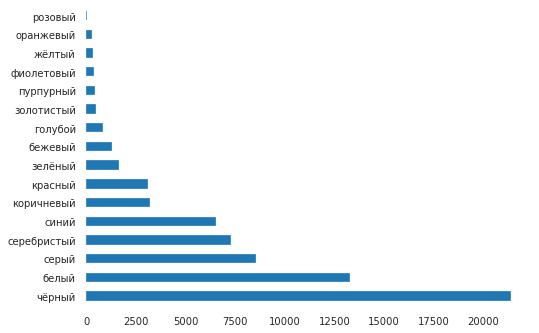

In [36]:
#посмотрим на распределение
data.color.value_counts().plot.barh()

In [37]:
#Дополнительной обработки признак не требует,пропусков нет,определяем его в "категориальные"
cat_cols.append('color')

**Description**

In [38]:
# сгенерируем числовой признак - количество символов в описании
data['description_len'] = data.description.apply(lambda x: len(str(x)))
# сам description удалим
data = data.drop('description',axis=1)

In [39]:
#Определим его как числовой признак
num_cols.append('description_len')

**fuelType**

In [40]:
data.fuelType.value_counts()

бензин     56234
дизель     12377
гибрид       416
электро      141
газ           13
Name: fuelType, dtype: int64

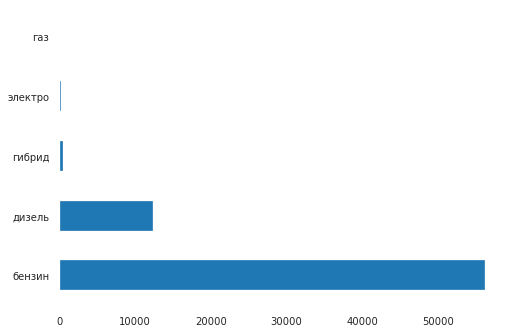

In [41]:
#посмотрим на распределение
data.fuelType.value_counts().plot.barh()

пропусков нет, дополнительной обработки не требуется, добавим признак в категориальные

In [42]:
#пропусков нет,определяем его в "категориальные"
cat_cols.append('fuelType')

**image**

In [43]:
# image - фото автомобиля
# проверим фото на уникальность
count_photos = data.image.value_counts()
count_photos.head(5)

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr     20
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr    13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016098487a9e1ff58d5ae35f3de345/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wizardv3mr     12
Name: image, dtype: int64

In [44]:
# image - фото автомобиля
# проверим фото на уникальность
count_photos = data.image.value_counts()
count_photos.head(5)

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr     20
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr    13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016098487a9e1ff58d5ae35f3de345/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wizardv3mr     12
Name: image, dtype: int64

In [45]:
# можно сделать из этого бинарный признак по типу уникальности фото
data['real_photo'] = data.image.apply(lambda x: x.find('get-verba') == -1)

real = data[data['real_photo'] == False].image.value_counts()

In [46]:
# сам признак image удалим
data = data.drop('image',axis=1)

In [47]:
data['real_photo'].value_counts()
#Реальных фото оказалось большинство

True     68618
False      563
Name: real_photo, dtype: int64

In [48]:
#пропусков нет,определяем его в бинарные
bin_cols.append('real_photo')

**engineDisplacement**

In [49]:
data.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '6.8 LTR', '0.8 LTR', '0.9 LTR', '6.4 LTR', '6.5 LTR',
       '0.6 LTR'], dtype=object)

In [50]:
#оставим только численное значение
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])
data.engineDisplacement = data.engineDisplacement.replace(' LT', '2.0')
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [51]:
#разобьем по категориям
data["engineDisplacement"] = data["engineDisplacement"].astype('float').apply(lambda x: 4 if x >= 4 else 
   3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
data.engineDisplacement.value_counts()

2    26800
1    23821
3    12821
4     5642
0       97
Name: engineDisplacement, dtype: int64

In [52]:
#пропусков нет,определяем его в "категориальные"
cat_cols.append('engineDisplacement')

**enginePower**

In [53]:
data.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [54]:
#преобразуем данные оставив первые цифры
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7')
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

<bound method Axes.barh of <matplotlib.axes._subplots.AxesSubplot object at 0x7f0141dc8410>>

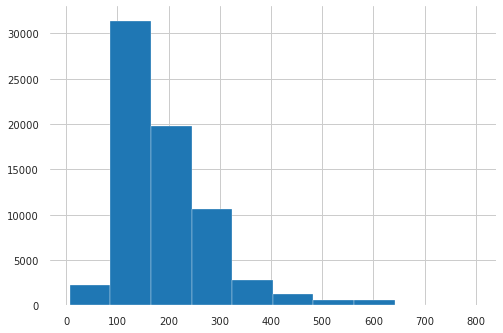

In [55]:
#посмотрим на распределение
data.enginePower.hist().barh

In [56]:
#добавим в числовой признак
num_cols.append('enginePower')

**mileage**

In [57]:
data['mileage'].value_counts()

200000        489
300000        426
150000        418
250000        403
180000        384
             ... 
42200           1
243499          1
220 740 км      1
120 422 км      1
6 599 км        1
Name: mileage, Length: 28328, dtype: int64

In [58]:
#Почистим данные от неразрывных пробелов и букв
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('км', '').replace('\xa0', ''))

data['mileage'].unique()

array(['74000', '60563', '88000', ..., '267740', '315164', '373317'],
      dtype=object)

In [59]:
# приведем к числовому типу
data['mileage'] = data.mileage.apply(lambda x: int("".join(filter(str.isdigit, x))))

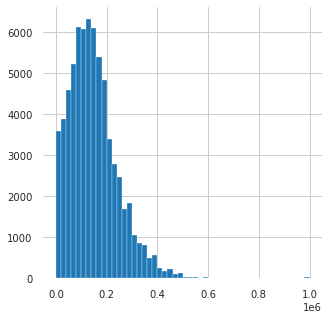

In [60]:
#посмотрим на распределение
data['mileage'].hist(figsize=(5,5), bins=50)

In [61]:
#Создадим категориальный признак 'mileage_cat'  
data["mileage_cat"] = data["mileage"].apply(lambda x: 4 if x>=40000 else(3 if x>=30000 else(2 if x>=20000 else (1 if x>=10000 else 0))))

In [62]:
data.mileage_cat.value_counts()

4    61809
3     2011
2     1846
1     1771
0     1744
Name: mileage_cat, dtype: int64

In [63]:
# определим эти признаки в числовые, и категориальные
num_cols.append('mileage')
cat_cols.append('mileage_cat')

**productionDate и modelDate**

2012    5642
2013    5233
2011    4963
2014    4782
2008    4560
        ... 
1962       1
1961       1
1957       1
1948       1
1949       1
Name: productionDate, Length: 74, dtype: int64

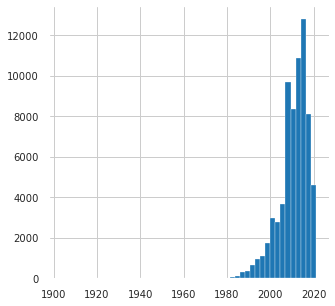

In [64]:
display(data.productionDate.value_counts())
#посмотрим на распределение
data['productionDate'].hist(figsize=(5,5), bins=50)

2013.0    4958
2012.0    4881
2011.0    4569
2014.0    4524
2010.0    4346
          ... 
1965.0       1
1950.0       1
1946.0       1
1934.0       1
1904.0       1
Name: modelDate, Length: 73, dtype: int64

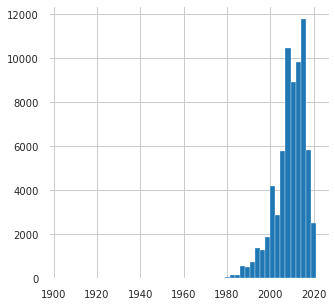

In [65]:
display(data.modelDate.value_counts())
#посмотрим на распределение
data['modelDate'].hist(figsize=(5,5), bins=50)

In [66]:
#создадим новые признаки на основе существующих: количество лет от производства и возраст модели
data['prod_age'] = 2021 - data.productionDate
data['model_age'] = 2021 - data.modelDate

In [67]:
#определим эти признаки в числовые
num_cols.append('productionDate')
num_cols.append('modelDate')
num_cols.append('prod_age')
num_cols.append('model_age')

**model_name**

In [68]:
display(data.model_name.value_counts())

OCTAVIA                         2471
5ER                             1719
CAMRY                           1475
POLO                            1410
E_KLASSE                        1402
                                ... 
Skoda Superb III Рестайлинг        1
SIMPLEX                            1
Tesla Model 3  I Performance       1
Citroen Berlingo II                1
Ford Escape I                      1
Name: model_name, Length: 2749, dtype: int64

In [69]:
cat_cols.append('model_name')

**numberOfDoors**

In [70]:
data.numberOfDoors.value_counts() 
#категориальный признак,не требующий доп.обработки

5.0    39346
4.0    26469
2.0     2192
3.0     1173
0.0        1
Name: numberOfDoors, dtype: int64

In [71]:
cat_cols.append('numberOfDoors')

**vehicleTransmission**

In [72]:
data.vehicleTransmission.value_counts()

автоматическая      39883
механическая        13217
роботизированная     8245
вариатор             7836
Name: vehicleTransmission, dtype: int64

In [73]:
#определяем в категориальный признак
cat_cols.append('vehicleTransmission')

**Владельцы**

In [74]:
data['Владельцы'].value_counts()

3 или более    28492
1 владелец     13732
2 владельца    11641
1 владелец      8509
2 владельца     6807
Name: Владельцы, dtype: int64

In [75]:
#почистим данные, оставим только количество владельцев
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x[0])).astype('int32')

In [76]:
data.Владельцы.value_counts()

3    28492
1    22241
2    18448
Name: Владельцы, dtype: int64

In [77]:
#пропусков нет,определяем его в "категориальные"
cat_cols.append('Владельцы')

**ПТС**

In [78]:
data.ПТС.value_counts()

Оригинал    60884
Дубликат     8296
Name: ПТС, dtype: int64

In [79]:
data.ПТС.isna().sum()

1

In [80]:
data.ПТС = data.ПТС.fillna('Оригинал')# заполним пропуск наиболее частым значением

In [81]:
# Преобразуем значения в колонке ПТС
data['ПТС'] = data['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

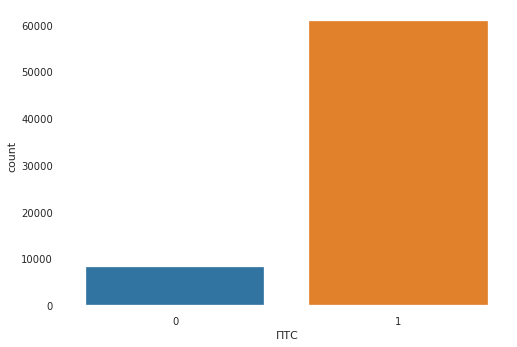

In [82]:
#посмотрим на распределение
sns.countplot(x = 'ПТС', data = data)

In [83]:
#определяем в бинарные признаки
bin_cols.append('ПТС')

**Привод**

In [84]:
data.Привод.value_counts()

полный      31088
передний    30916
задний       7177
Name: Привод, dtype: int64

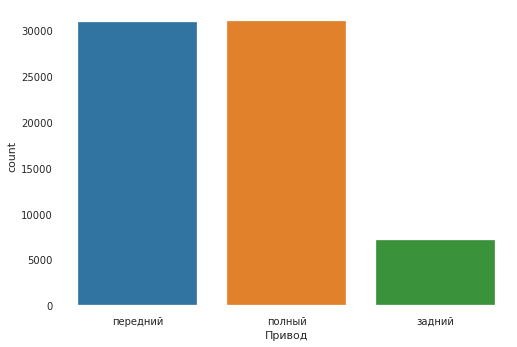

In [85]:
#посмотрим на распределение
sns.countplot(x = 'Привод', data = data)

In [86]:
#пропусков нет,определяем его в "категориальные"
cat_cols.append('Привод')

**Руль**

In [87]:
data.Руль.value_counts()

Левый     66917
Правый     2264
Name: Руль, dtype: int64

In [88]:
# Преобразуем значения в колонке Руль
data['Руль'] = data['Руль'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

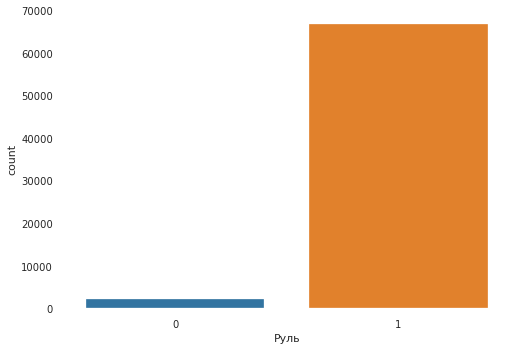

In [89]:
sns.countplot(x = 'Руль', data = data)

In [90]:
#определяем в бинарные признаки
bin_cols.append('Руль')

**Состояние**

In [91]:
data.Состояние.value_counts()

Не требует ремонта    69179
Битый / не на ходу        2
Name: Состояние, dtype: int64

In [92]:
# Преобразуем значения в колонке Состояние
data['Состояние'] = data['Состояние'].apply(lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')

In [93]:
data.Состояние.value_counts()

1    69179
0        2
Name: Состояние, dtype: int64

In [94]:
#определяем в бинарные признаки
bin_cols.append('Состояние')

**Посмотрим на распределение целевой переменной:**

In [95]:
# приведем целевую переменную к числовому типу
data['price'] = data['price'].apply(lambda x: str(x))
data.price = data.price.apply(lambda x: ("".join(filter(str.isdigit, x)))).astype('int')


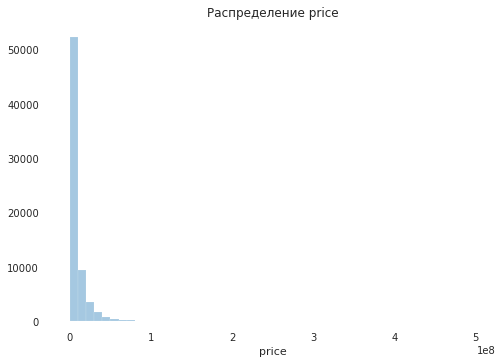

In [96]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(data.price, kde=False)

Посмотрим на распределение зависимости цены от марки авто:

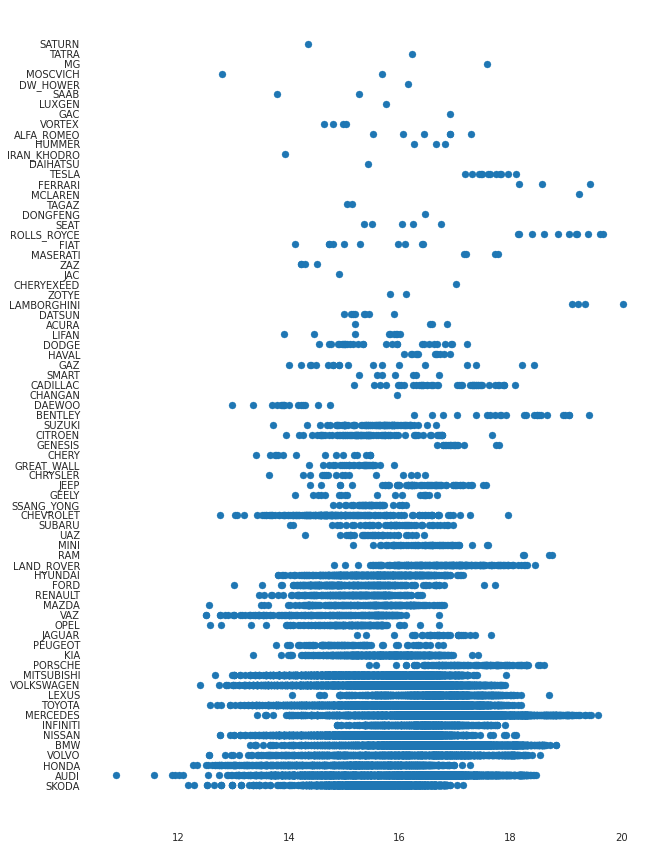

In [97]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.brand)

Посмотрим на распределение зависимости цены от километража

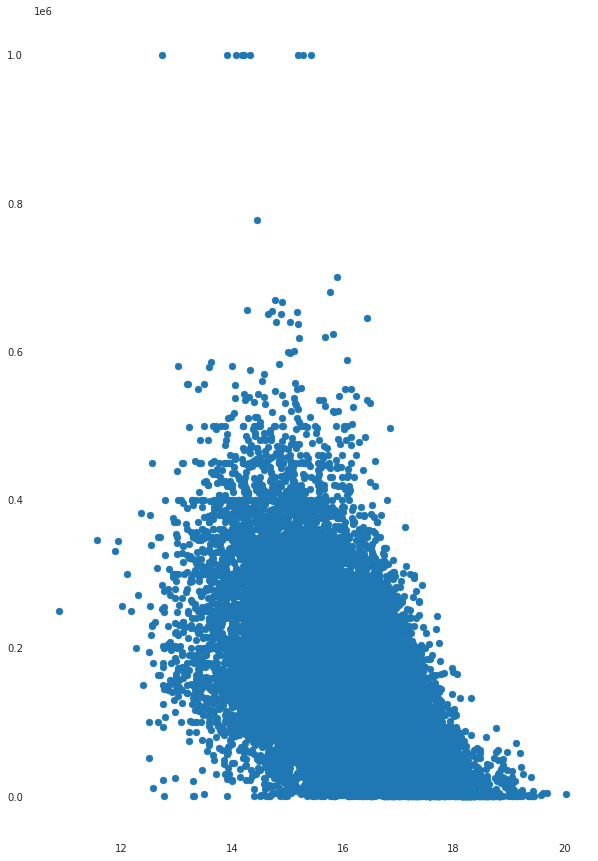

In [98]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.mileage)

 Удалим признаки, которые на наш взгляд не несут никакой информативности,либо дублируют информацию:

In [99]:
data = data.drop(columns = ['car_url','name','parsing_unixtime','vehicleConfiguration','priceCurrency','Таможня'], axis=1)

## Label Encoding

In [100]:
# преобразуем даные в категориальные
for colum in ['bodyType','color','model_name','brand','fuelType', 'vehicleTransmission','Привод','real_photo']:
    data[colum] = data[colum].astype('category').cat.codes

In [101]:
data.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,Привод,Руль,Состояние,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
1042,6,59,1,1,110,0,84000,2012.0,2166,5.0,...,1,1,1,0,0,122,1,4,4,9.0
51422,4,44,7,2,184,0,92519,2013.0,755,2.0,...,0,1,1,12700000,1,1127,1,4,8,8.0
30798,11,70,15,1,110,0,57000,2014.0,1048,4.0,...,1,1,1,0,0,278,1,4,5,7.0
26335,17,70,12,1,102,0,150000,2003.0,845,5.0,...,1,1,1,0,0,70,1,4,13,18.0
61370,8,67,1,2,132,0,260000,1995.0,878,4.0,...,0,1,1,1861710,1,159,1,4,26,26.0


In [102]:
print('Категориальныe: {} \nБинарные: {}\nЧисловые: {}'.format(cat_cols, bin_cols,num_cols))

Категориальныe: ['bodyType', 'brand', 'color', 'fuelType', 'engineDisplacement', 'mileage_cat', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
Бинарные: ['real_photo', 'ПТС', 'Руль', 'Состояние']
Числовые: ['description_len', 'enginePower', 'mileage', 'productionDate', 'modelDate', 'prod_age', 'model_age']


# Бинарные признаки

In [103]:
for i in bin_cols:
    display(data[i].value_counts())

1    68618
0      563
Name: real_photo, dtype: int64

1    60885
0     8296
Name: ПТС, dtype: int64

1    66917
0     2264
Name: Руль, dtype: int64

1    69179
0        2
Name: Состояние, dtype: int64

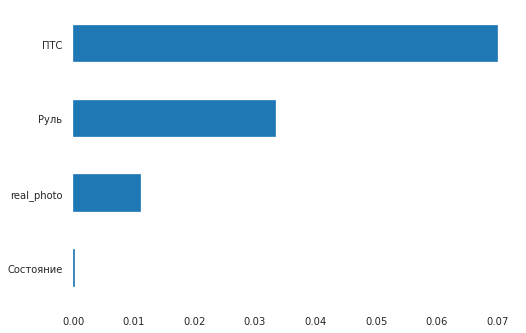

In [104]:
#Проверим значимость бинарных переменных:
df = data[data['sample'] == 0]
imp_cat = Series(mutual_info_classif(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

по графику видим,что сильно больше всего влияют признаки ПТС и Руль на цену

# Категориальные признаки

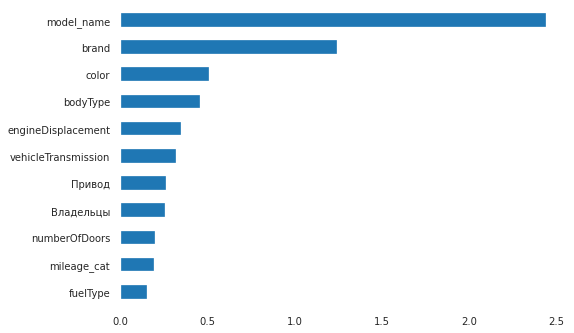

In [105]:
# Проверим значимость категориальных переменных:
temp_df = data[data['sample'] == 1]
imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Логично,что цена будет зависеть от марки и модели машины

# Числовые признаки

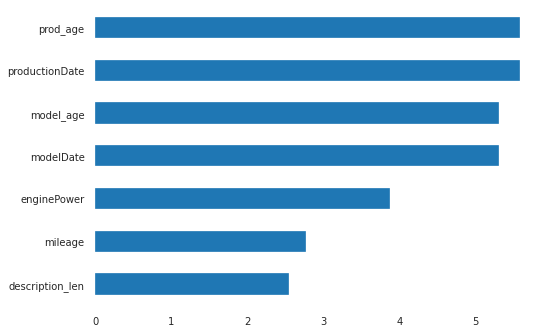

In [106]:
imp_num = Series(f_classif(data[num_cols][data['sample'] == 1], data[data['sample'] == 1]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Все признаки достаточно сильно влияют на цену

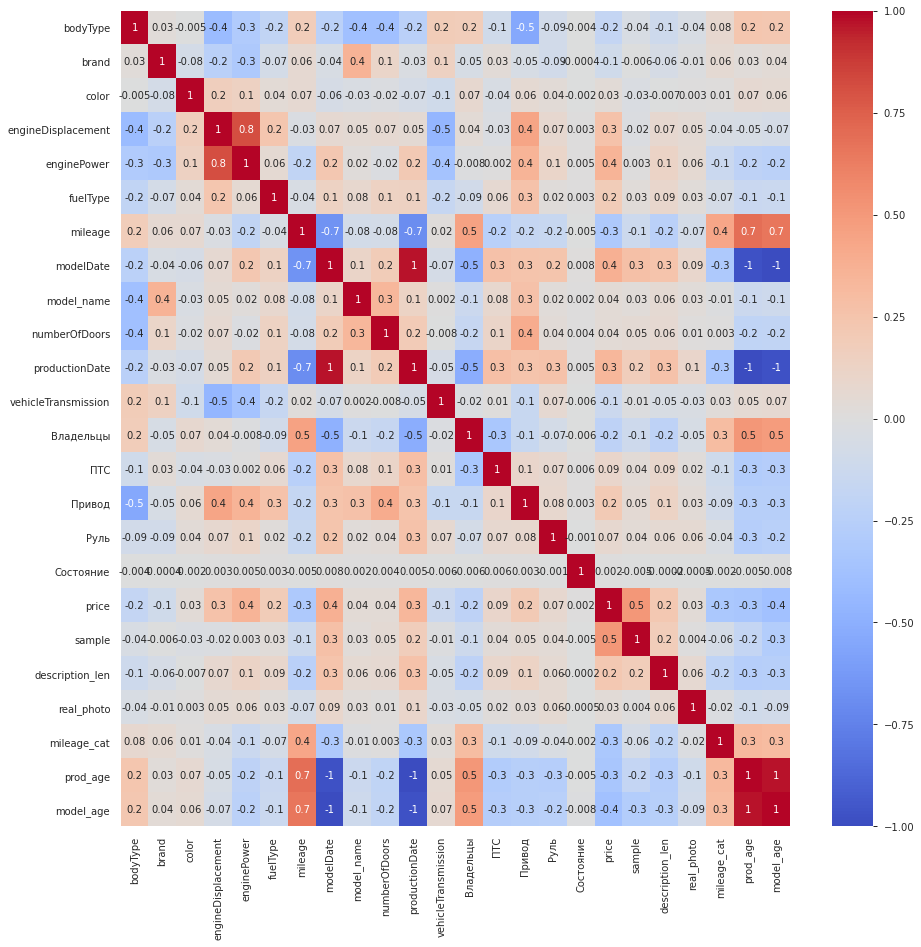

In [107]:
# построим матрицу корреляций
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

Видна большая корреляция между признаками 'engineDisplacement' и 'enginePower', а так же искусственно созданными признаками. Удалять не будем, тк проведя эксперименты по машинному обучению, заметили что результат метрики хуже.

## Train Split

In [108]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [109]:
train_data

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,ПТС,Привод,Руль,Состояние,price,description_len,real_photo,mileage_cat,prod_age,model_age
34686,8,44,15,2,190,3,15,2014.0,1819,5.0,...,1,2,1,1,149450000,53,1,0,1,7.0
34687,0,67,12,2,158,0,180000,2010.0,2504,5.0,...,1,2,1,1,9515390,847,1,4,10,11.0
34688,0,44,7,2,245,0,47000,2015.0,1664,5.0,...,1,2,1,1,32000000,399,1,4,4,6.0
34689,3,2,12,2,400,0,66000,2016.0,183,2.0,...,1,2,1,1,6459910,294,1,4,5,5.0
34690,0,52,6,2,252,0,6000,2018.0,2117,5.0,...,1,2,1,1,29912560,87,1,0,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71784,17,27,7,1,115,0,373317,1999.0,558,5.0,...,0,1,1,1,1902040,162,1,4,22,22.0
71785,2,27,11,1,130,0,311000,2002.0,2297,5.0,...,1,1,0,1,2988930,989,1,4,19,19.0
71786,11,27,12,1,140,0,196000,2008.0,558,4.0,...,0,1,1,1,3894660,398,1,4,13,13.0
71787,17,27,13,1,90,0,350000,2000.0,558,5.0,...,0,1,1,1,1222740,208,1,4,21,21.0


# Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.


In [110]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [111]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
VERSION = 1
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values)) * 100:0.2f}%")

Точность наивной модели по метрике MAPE: 102.61%


# Простая модель линейной регрессии

In [112]:
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
VERSION = 2
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 41.92%


# CatBoost

In [113]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         )

model.save_model('catboost_single_model_baseline.model')

In [114]:
# оцениваем точность
predict = model.predict(X_test)
predict_submission = model.predict(test_data)
VERSION = 3
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict)) * 100:0.2f}%")

Точность модели по метрике MAPE: 20.70%


### Log Target
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    

In [115]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(test_data))
VERSION = 4
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 16.37%


# Random Forest

In [116]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train, np.log(y_train+1))
predict_submission = np.exp(rf.predict(test_data))
VERSION = 5
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test)))) * 100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Точность модели по метрике MAPE: 19.79%


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [117]:
#Зададим сетку гиперпараметров, которые будут перебираться:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [118]:
#Обучим наш лес:
#rf = RandomForestRegressor(random_state=RANDOM_SEED).fit(X_train, np.log(y_train+1))
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                              cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
#rf_random.fit(X_train, np.log(y_train+1))

In [119]:
VERSION = 6
#predict_submission = np.exp(rf_random.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test)))) * 100:0.2f}%")

Точность модели по метрике MAPE: 19.79%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


# xgboost

In [120]:
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
VERSION = 7
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 15.98%


In [121]:
sample_submission['price'] = np.round(predict_submission,-3).astype('int')
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,5203000
1,1100549428,7616000
2,1100658222,7412000
3,1100937408,6334000
4,1101037972,5879000


# GradientBoosting с подбором параметров

In [122]:
def regularise(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [123]:
#best_max_depth, best_n_estimators = regularise(X_train, y_train)
#best_max_depth, best_n_estimators

In [124]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb.fit(X_train, np.log(y_train+1))
VERSION = 8
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 17.99%


# Stacking

In [125]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [126]:
regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
                            KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs=-1, verbose=1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

In [127]:
def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)
VERSION = 9
#print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

# Submission

In [128]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,5202864.0
1,1100549428,7615967.0
2,1100658222,7412150.0
3,1100937408,6334460.0
4,1101037972,5879048.0


Проведя ряд экспериментов можно сделать следующие выводы:
* CatBoost и GradientBoosting отлично справляется и показывает хороший результат метрики, но лучший результат показал xgboost - 15.75%.
* Заметно улучшается результат после логарифмирования целевой переменной
* так же удалось поэксперементировать со стекингом с различными мета-алгоритмами.

Результаты можно улучшить спарсив больше данных и провести больше обработки над признаками, создав новые, но из-за того что проект затянул - не стал делать.
Долго разбирался почему результат сабмишена 132%, хотя при записывании submission_2_v7 точность модели по метрике MAPE была 15.75%.
Выяснилось, что нужен учет инфляции в разделе препроцессинга.